In [1]:
# -*- coding: utf-8 -*-
"""
Untitled7.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1TwVF_GQ5CsCF3A6aXPaRixsN7MYPKJxc

"""

'\nUntitled7.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1TwVF_GQ5CsCF3A6aXPaRixsN7MYPKJxc\n\n'

### Package version syncing
#### To save your time, do not run this if you have done once in your environment!!!

In [2]:
# Commented out IPython magic to ensure Python compatibility.
# !pip install tensorflow==2.7.0
# !pip install tensorflow-quantum==0.7.2

## imports

In [3]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

In [4]:
# visualization tools
# %matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [5]:
# Commented out IPython magic to ensure Python compatibility.
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

In [6]:
# visualization tools
# %matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Data loading

In [7]:
# load data mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#cek length of data 
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print(x_train.shape, x_test.shape)

Number of original training examples: 60000
Number of original test examples: 10000
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Filt 3 and 6 (Why?)

Number of filtered training examples: 12049
Number of filtered test examples: 1968
True


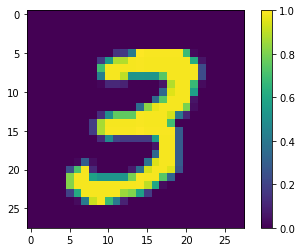

In [8]:
#function for filter data number 3 dan number 6 
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

## Data squeezing (need to be change)

True


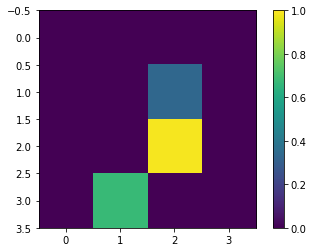

In [9]:
# filter data to 4 x 4 size 
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

# data image after resize 
print(y_train[0])
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [10]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


## Circuit

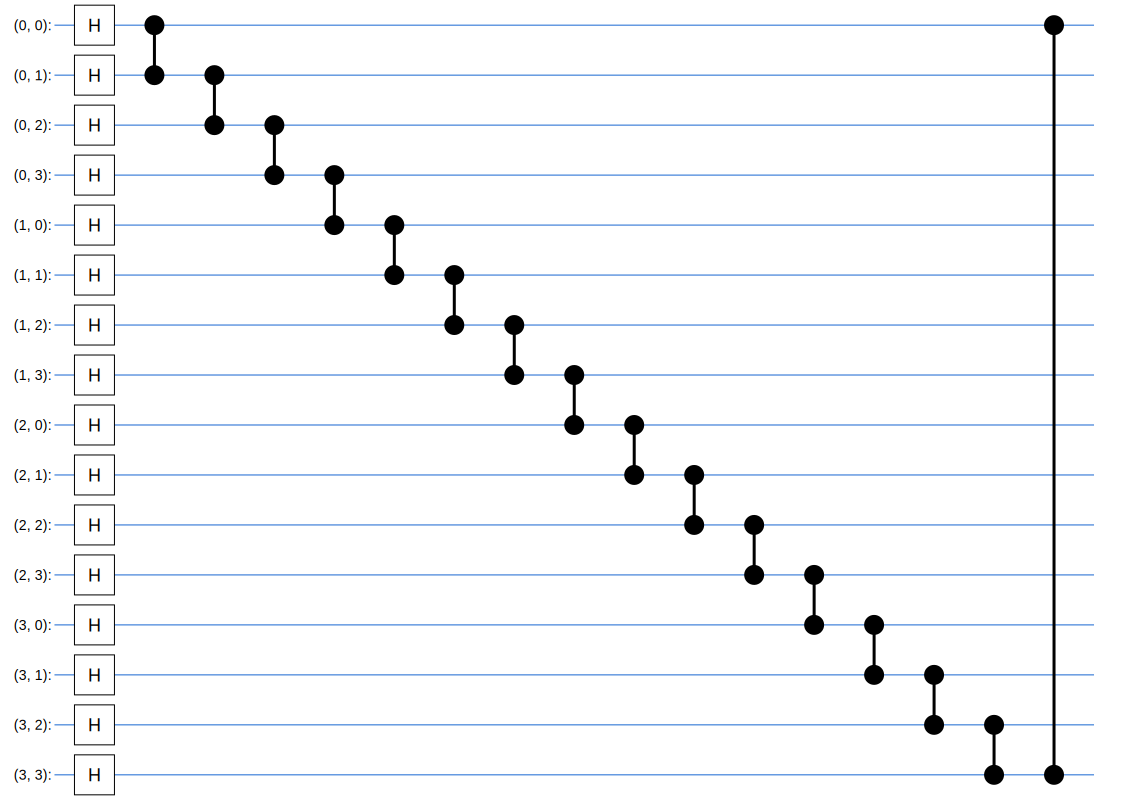

In [11]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

cluster_state_bits = cluster_state_circuit(cirq.GridQubit.rect(4, 4))

SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(4, 4)))

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit

# convert data to circuit 
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# convert data to tensor format 
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

print(x_train_tfcirc.shape , x_test_tfcirc.shape)

bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T

# change data target to 1 or -1 
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

print(y_train_hinge.shape, y_test_hinge.shape)

(10338,) (1968,)
(10338,) (1968,)


In [13]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])
    

    
def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit
  
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit


class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(1,2)
circuit = cirq.Circuit()


symbols = sympy.symbols('qconv0:84')
circuit += quantum_conv_circuit(qubits , symbols[0:15]) # range symbols always 16
circuit += quantum_pool_circuit(qubits[:8], qubits[8:], symbols[15:21])


readout_qnn = cirq.GridQubit(1, 3)
data_qubits_qnn = cirq.GridQubit.rect(4, 4)[8:]

builder = CircuitLayerBuilder( data_qubits = data_qubits_qnn, readout=readout_qnn)

In [14]:
# Then add layers (experiment by adding more).
builder.add_layer(circuit, cirq.XX, "xx1")
builder.add_layer(circuit, cirq.ZZ, "zz1")

model_readout = circuit.append(cirq.H(cirq.GridQubit(1, 3)))

SVGCircuit(circuit)

readout_operators = cirq.Z(qubits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(qubits))

quantum_model = tfq.layers.PQC(circuit,
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

print(len(y_train_hinge), x_train_tfcirc.shape)
print(len(y_test_hinge), x_test_tfcirc.shape)

10338 (10338,)
1968 (1968,)


In [15]:
EPOCH = 5
BATCH_SIZE = 32

NUM_EXAMPLES = 500
#NUM_EXAMPLES = len(x_train_tfcirc)

NUM_EXAMPLES

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

print(x_train_tfcirc_sub.shape , y_train_hinge_sub.shape)


collections.Counter(y_train_hinge_sub)

(500,) (500,)


Counter({1.0: 230, -1.0: 270})

In [16]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[hinge_accuracy])

history = qcnn_model.fit(x=x_train_tfcirc_sub,
                         y=y_train_hinge_sub,
                         batch_size=16,
                         epochs=EPOCH,
                         verbose=1,
                         validation_data=(x_test_tfcirc , y_test_hinge))

import pandas as pd
df_history = pd.DataFrame()
df_history['accuracy']  = history.history['hinge_accuracy']
df_history['loss']      = history.history['loss']
df_history['val_accuracy'] = history.history['val_hinge_accuracy']
df_history['val_loss']  = history.history['val_loss']

df_history.to_csv("history.csv", index = False)

print(df_history.shape)
df_history.head()

Epoch 1/5
32/32 [==============================] - 38s 1s/step - loss: 0.6636 - hinge_accuracy: 0.7793 - val_loss: 0.4982 - val_hinge_accuracy: 0.7698
Epoch 2/5
32/32 [==============================] - 37s 1s/step - loss: 0.4881 - hinge_accuracy: 0.7891 - val_loss: 0.4568 - val_hinge_accuracy: 0.8333
Epoch 3/5
32/32 [==============================] - 36s 1s/step - loss: 0.4813 - hinge_accuracy: 0.8027 - val_loss: 0.4888 - val_hinge_accuracy: 0.7698
Epoch 4/5
32/32 [==============================] - 36s 1s/step - loss: 0.4699 - hinge_accuracy: 0.7852 - val_loss: 0.4724 - val_hinge_accuracy: 0.7698
Epoch 5/5
32/32 [==============================] - 36s 1s/step - loss: 0.4727 - hinge_accuracy: 0.7676 - val_loss: 0.4349 - val_hinge_accuracy: 0.8333
(5, 4)


,accuracy,loss,val_accuracy,val_loss
0,0.779297,0.663645,0.769817,0.498219
1,0.789062,0.488118,0.833333,0.456765
2,0.802734,0.481298,0.769817,0.488814
3,0.785156,0.469864,0.769817,0.472352
4,0.767578,0.472715,0.833333,0.434878
